

<h1 align="center">Navigating the Allen Brain Observatory</h1> 
<h3 align="center">Regressing neural activity against running</h3>
<h3 align="center">CSHL Neural Data Analysis</h3>
<h3 align="center">Tuesday July 23, 2019</h3> 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
drive_path = '/data/allen-brain-observatory/visual-coding-2p'
manifest_file = os.path.join(drive_path,'manifest.json')

boc = BrainObservatoryCache(manifest_file=manifest_file)

/Users/saskiad/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1> Part 1: Get the data you need. </h1>

</div>

Use the cell id you used earlier. Or switch with a friend. Get the data for this experiment and get the dff traces and running speed

In [280]:
cell_id = 662074297#541513979

In [281]:
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_id], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

2019-07-19 21:04:21,602 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/606290198


In [282]:
timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_id])
dff_trace = dff[0,:]

Text(0,0.5,u'DFF')

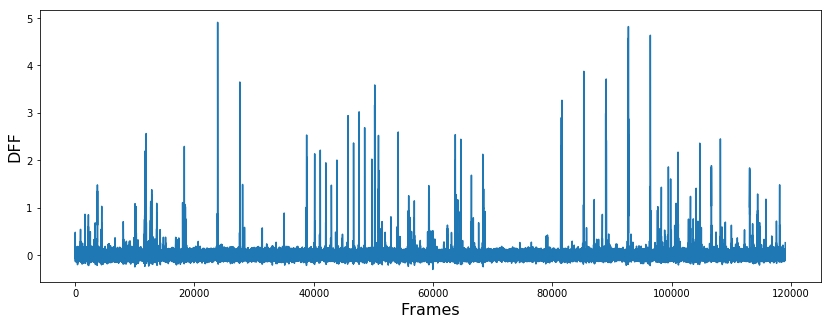

In [283]:
plt.figure(figsize=(14,5))
plt.plot(dff_trace)
plt.xlabel("Frames", fontsize=16)
plt.ylabel("DFF", fontsize=16)

In [284]:
dxcm, ts = data_set.get_running_speed()

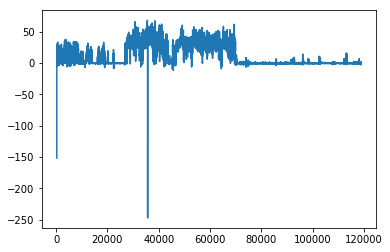

In [285]:
plt.plot(dxcm)

Plot the running speed of the mouse in this experiment. How much time does the mouse spend running?

In [288]:
ts, dff = data_set.get_dff_traces()

In [289]:
dff.shape

(41, 119024)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1> Part 2: How well can we predict the summed activity of all neurons using running speed?</h1>


</div>

We're going to start by trying to use the running speed to predict the total activity of all the neurons in this experiment.

Running activity is fairly coarse, so rather than try to predict the activity at 30Hz, let's bin the activity (summed across all neurons) into bins of 5 seconds

(20000, 40000)

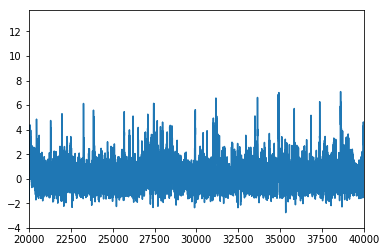

In [392]:
plt.plot(dff.sum(axis=0))
plt.xlim(20000,40000)

In [ ]:
num_bins = int(ts.max())/5

In [376]:
run_bin = np.empty((numbins))
response_bin = np.empty((numbins))

In [377]:
for i in range(num_bins):
    run_bin[i] = dxcm[np.where((ts>i*5)&(ts<((i+1)*5)))].mean()
    response_bin[i] = dff[:,np.where((ts>i*5)&(ts<((i+1)*5)))].mean()

The running trace has NaNs - as the running data is recorded for slightly less time than the 2P imaging. Remove the NaNs from the running trace, and remove those same data points from the summed activity trace.

In [378]:
response_bin = response_bin[np.isfinite(run_bin)]
run_bin = run_bin[np.isfinite(run_bin)]

In [369]:
response_bin.shape

(765,)

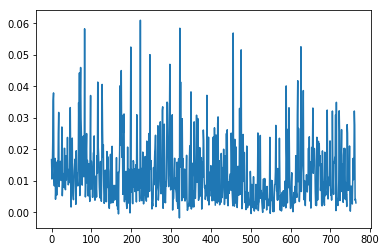

In [370]:
plt.plot(response_bin)

In [371]:
run_bin.shape

(765,)

Use <b>scipy.linalg.lstsq</b> to do a linear regression. Be sure to hold out data to use to test the regression. (suggestion: look at your running trace to make smart choices about what chunk of data to hold out) 

In [393]:
from scipy.linalg import lstsq

In [379]:
response_bin -= response_bin.mean()
run_bin -= run_bin.mean()
coef = lstsq(run_bin[200:,None], response_bin[200:,None])[0][0]
print(coef)

[  2.86347015e-05]


Test your regression on the held out data. Compute the pearson coefficient of your prediction with the data. How well did you predict the running?

In [382]:
predict = coef*run_bin[:200]

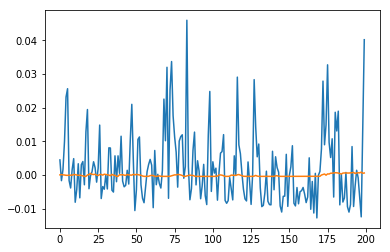

In [383]:
plt.plot(response_bin[:200])
plt.plot(predict)

In [384]:
st.pearsonr(response_bin[:200], predict)

(0.11578490502344981, 0.10253672308423427)

The regression you just did was just a linear prediction, but perhaps the relationship isn't linear. Repeat the process to do a polynomial prediction. Does your prediction improve?

In [385]:
run_table = np.empty((len(run_bin), 5))
for i in range(5):
    run_table[:,i] = np.power(run_bin, i+1)

In [386]:
coef = lstsq(run_table[200:,:], response_bin[200:,None])[0]
print(coef)

[[ -5.74566880e-04]
 [  3.33976237e-05]
 [  3.19806170e-06]
 [ -2.48522555e-07]
 [  4.06571071e-09]]


In [387]:
predict = np.zeros((len(run_bin[:200])))
for i in range(5):
    predict += coef[i][0]*np.power(run_bin[:200], i+1)

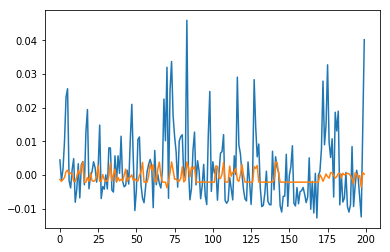

In [388]:
plt.plot(response_bin[:200])
plt.plot(predict)

In [389]:
st.pearsonr(response_bin[:200], predict)

(0.26148087229444078, 0.0001840213337929581)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1> Part 3: How well can we predict the activity of individual neurons using running speed?</h1>
Do the same process for individual neurons. What the best prediction you get? What is the equation for that prediction?

</div>

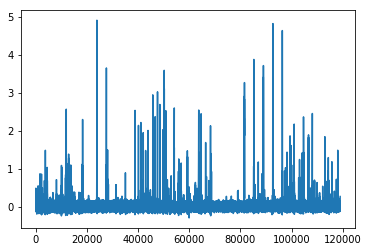

In [342]:
plt.plot(dff_trace)

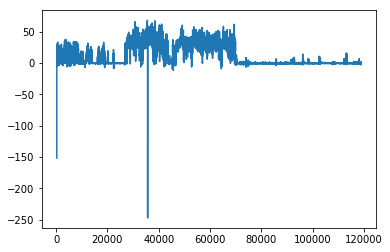

In [350]:
plt.plot(dxcm)

In [356]:
run_bin = np.empty((int(ts.max())/5))
response_bin = np.empty((int(ts.max())/5))

In [357]:
for i in range(int(ts.max())/5):
    run_bin[i] = dxcm[np.where((ts>i*5)&(ts<((i*5)+5)))].mean()
    response_bin[i] = dff_trace[np.where((ts>i*5)&(ts<((i*5)+5)))].mean()

In [358]:
response_bin = response_bin[np.isfinite(run_bin)]
run_bin = run_bin[np.isfinite(run_bin)]
response_bin -= response_bin.mean()
run_bin -= run_bin.mean()
coef = lstsq(run_bin[200:,None], response_bin[200:,None])[0][0]
print(coef)

[  8.20662398e-06]


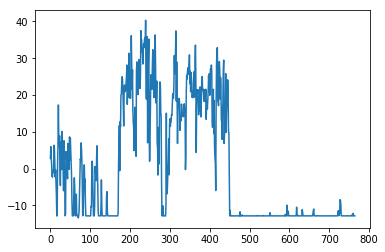

In [355]:
plt.plot(run_bin)

In [359]:
predict = coef*run_bin[:200]

In [365]:
st.pearsonr(response_bin[:200],predict)

(0.012070000679650925, 0.86529968298467541)

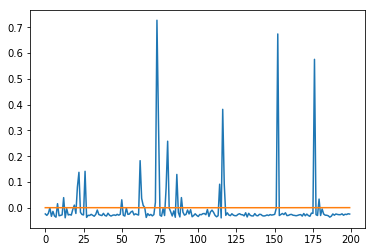

In [362]:
plt.plot(response_bin[:200])
plt.plot(predict)

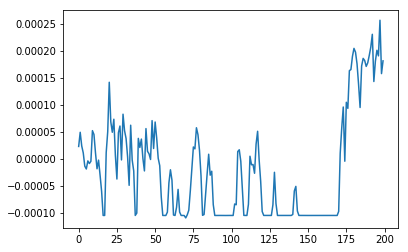

In [363]:
plt.plot(predict)